# Real NVP (non-volume-preserving) flows

__Note:__ it looks like `tfb.real_nvp_default_template` doesn't produce trainable variables that either Keras or Tensorflow can track. This is probably related to [this issue](https://github.com/tensorflow/probability/issues/1439). To overcome this, a `Layer` subclass is defined, using Keras `Dense` layers to mimic what `tfb.real_nvp_default_template` - in which case variables are correctly tracked.

__Objective:__ train a real NVP model.

Source: [here](https://github.com/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_04.ipynb)

**Idea:** build an alternative to inverse autoregressive flows that singles out the first $n$ dimensions. Working on $d$-dimensional event space, as with inverse autoregressive flows we start from a "complicated space" with points $\mathbf{z}\in\mathbb{R}^d$ distributed according to the probability density function $p_z(\mathbf{z})$ we'd like to model. We want to find a transformation $\mathbf{G}$ whose inverse maps points $\mathbf{z}$ to points $\mathbf{x}\in\mathbb{R}^d$, with the distribution becoming $p_x(\mathbf{x})$, which we want to be very simple (e.g. a multivariate isotropic Gaussian). In direct form, $\mathbf{x} = \mathbf{G}(\mathbf{z})$. In real NVP flows, $\mathbf{G}$ is taken to be the identity for the first $n$ components (working one component at a time, on the corresponding one),

$$
x_i = G_i(\mathbf{z}) = z_i\quad \forall i = 1, \ldots, n\,,
$$

while for the remaining $d - n$ components $\mathbf{G}$ is taken to be an affine transformation of the corresponding components, with parameters depending **only on the first $n$ components** and given by a neural networks,

$$
x_i = G_i(\mathbf{z}) = \exp\left( \alpha_i(z_1, \ldots, z_n) \right)\, z_i + b(z_1, \ldots, z_n)\quad \forall i = n + 1, \ldots, d\,.
$$

Tensorflow Probability provides the following implementation:
- `tfp.bijectors.Bijector`: the general class implementing an invertible transformation (a normalizing flow).
- `tfp.bijectors.RealNVP`: the bijector implementing the full real NVP flow.

As per the first note, `tfb.real_nvp_default_template`, so the network returning the parameters for the affine transformations was written by hand.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_theme()

## Generate data

Generate a complicated distribution of points in 2 dimensions.

In [2]:
n_samples = 2500

x2_samples = tfd.Normal(loc=0., scale=4.).sample(n_samples)

x1_samples = tfd.Normal(loc=.25 * tf.square(x2_samples), scale=tf.ones(n_samples, dtype=tf.float32)).sample()

samples = tf.stack(
    [x1_samples, x2_samples],
    axis=1
) / 40.

samples

2023-10-13 14:43:00.814377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(2500, 2), dtype=float32, numpy=
array([[-0.01271388,  0.01504668],
       [-0.0250626 ,  0.04325525],
       [ 0.04170093,  0.06044582],
       ...,
       [ 0.31300482,  0.18098931],
       [ 0.3734166 , -0.19021511],
       [ 0.17722334,  0.14394727]], dtype=float32)>

Text(0.5, 1.0, 'Samples')

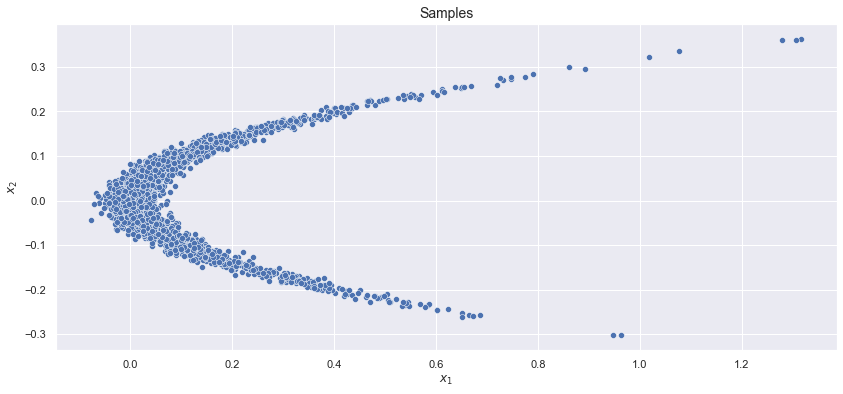

In [3]:
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=samples[:, 0],
    y=samples[:, 1],
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

## Build the NVP model

Build the model as a Keras `Model` object (subclass).

In [211]:
class RealNVPLayer(tf.keras.layers.Layer):
    """
    Subclass of Keras `Layer` implementing a single
    two-headed layer providing the parameters to a
    `tfb.RealNVP` bijector. "Single" means that the
    parameters are given by a single Dense layer
    each (not by deep NNs).
    """
    def __init__(self, full_dim, num_masked):
        """
        Class constructor. The number of units are chosen
        to have the same input and outupt shapes as
        `tfp.bijectors.real_nvp_default_template`, with the
        dense layers expecting only the first n dimensions
        of the d-dimensional input tensors and outputting
        tensors of dimension (d - n) corresponding to the
        (d - n) parameters alpha_i and b_i (i = n + 1, ...,
        d).
        
        Example: for 2-dimensional data, full_dim = 2 and
                 num_masked = 2, so that the dense layers
                 have a 1-dimensional input (the first
                 component of the full input) and a 1-dimensional
                 output (alpha and b for the second dimension
                 only).
        """
        super().__init__()
        
        self.full_dim = full_dim
        self.num_masked = num_masked
        
        self.dense_alpha = Dense(
            units=full_dim - num_masked,
            activation='relu'
        )
        self.dense_b = Dense(
            units=full_dim - num_masked,
            activation='relu'
        )
        
        
    def call(self, x, *inputs):
        """
        Forward pass. The alpha_i and b_i parameters are
        computed separately from the same input tensor and
        then returned in a tuple, copying the behaviour of
        the `tfp.bijectors.real_nvp_default_template` object.
        """
        output = (
            self.dense_alpha(x),
            self.dense_b(x)
        )
        
        return output

        
class RealNVPDeepLayer(tf.keras.layers.Layer):
    """
    Subclass of Keras `Layer` implementing a two-headed
    layer providing the parameters to a `tfb.RealNVP`
    bijector. Compared to the `RealNVPLayer` object,
    here the parameters are provided by a deep NN.
    """
    def __init__(self, full_dim, num_masked, hidden_layers):
        """
        Class constructor. The number of units are chosen
        to have the same input and outupt shapes as
        `tfp.bijectors.real_nvp_default_template`, with the
        dense layers expecting only the first n dimensions
        of the d-dimensional input tensors and outputting
        tensors of dimension (d - n) corresponding to the
        (d - n) parameters alpha_i and b_i (i = n + 1, ...,
        d).
        The NN outputting the parameters alpha_i and b_i
        has a number of hidden layers equal to the length of
        the `hidden_layers` list and provides an output of
        dimension 2 * (d - n) that is then split, with the
        first (d - n) components givin the alpha_i and the
        remaining (d - n) giving the b_i. Note: the implementation
        works with d=2 and n=1 and hasn't been tested in
        higher dimensions (the indexing might not be general!).

        Example: for 2-dimensional data, full_dim = 2 and
                 num_masked = 2, so that the dense layers
                 have a 1-dimensional input (the first
                 component of the full input) and a 1-dimensional
                 output (alpha and b for the second dimension
                 only).
        """
        super().__init__()
        
        self.full_dim = full_dim
        self.num_masked = num_masked
        self.hidden_layers = hidden_layers

        # List of hidden Dense layers, with the specified
        # number of units.
        self.dense_layers = [
            Dense(
                units=n_units,
                activation='relu'
            )
            for n_units in self.hidden_layers
        ]

        # Output layer.
        self.dense_layers.append(
            Dense(
                units=2 * (full_dim - num_masked),
                activation=None
            )
        )


    def call(self, x, *inputs):
        """
        Forward pass. The alpha_i and b_i parameters are
        computed separately from the same input tensor and
        then returned in a tuple, copying the behaviour of
        the `tfp.bijectors.real_nvp_default_template` object.
        """
        for layer in self.dense_layers:
            x = layer(x)
            
        alpha = x[..., :1]
        b = x[..., 1:]
        
        return (alpha, b)


class RealNVP(tf.keras.Model):
    """
    Subclass of a Keras `Model` object implementing a real
    NVP flow.
    """
    def __init__(self, *, output_dim, num_masked, hidden_layers, **kwargs):
        """
        Constructor of the real NVP.
        """
        super().__init__(kwargs)
        
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.nets = []
        
        bijectors = []
        
        # Number of layers.
        num_blocks = 5
        
        use_hidden_layers = not ((hidden_layers is None) or (hidden_layers == 0))
        
        if use_hidden_layers:
            print('Instantiating real NVP model with hidden layers')
        else:
            print('Instantiating real NVP model with no hidden layer')
        
        # Each block (layer) is composed of a real NVP flow and a
        # permutation, written in this order but then applied in
        # reversed order (first the permutation, then the real NVP).
        # The resulting first permutation is actually discarded (see
        # below).
        for i in range(num_blocks):
            # Build a function to be used to compute the affine
            # parameters in the real NVP (in this case, a NN).
            # net = tfb.real_nvp_default_template(
            #     hidden_layers=[h, h]  # Number of units in each hidden layer (two heads).
            # )
            if not use_hidden_layers:
                net = RealNVPLayer(full_dim=2, num_masked=1)
            else:
                net = RealNVPDeepLayer(full_dim=2, num_masked=1, hidden_layers=hidden_layers)
            
            # Instantiate a real NVP object and append it to
            # the list of bijectors.
            bijectors.append(
                tfb.RealNVP(
                    shift_and_log_scale_fn=net,
                    # Number of masked dimensions.
                    # Note: in 2 dimensions this can only be 1 to get a
                    #       nontrivial case.
                    num_masked=num_masked
                )
            )
            
            # Instantiate a bijector implementing the permutation
            # operation among dimensions, so that singling out the
            # first n dimensions in the real NVP doesn't select
            # the same ones in each layer (block).
            # Note: the argument is the permutation to be used,
            #       which in our 2-dimensional case can be only
            #       [1, 0] ([0, 1] would be the identity).
            bijectors.append(tfb.Permute([1, 0]))
            
            # Append the neural network function (parametrizing the
            # affine parameters) to keep track of it.
            self.nets.append(net)
            
        # Build the full bijector corresponding to the real NVP by
        # chaining together the bijectors in the `bijectors` list.
        # Notes: 
        #   * We reverse the list of bijectors so that they are
        #     applied in reversed order w.r.t. the one we populated
        #     the list with.
        #   * Before reversing the list, we leave out the last biijector,
        #     which whould be a useless initial permutation.
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        # Instantiate the flow object: a distribution obtained starting
        # from simple source distribution and then applying the full
        # bijector obtained above.
        self.flow = tfd.TransformedDistribution(
            # Source distribution.
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            # Bijector (NF) to apply.
            bijector=bijector
        )
        
    def call(self, *inputs):
        """
        Forward pass, corresponding to the forward transformation
        of the full bijector.
        """
        return self.flow.bijector.forward(*inputs)

In [212]:
# Test the custom layers.
print('Test with no hidden layers:')
print(
    tfb.RealNVP(
        num_masked=1,
        shift_and_log_scale_fn=RealNVPLayer(full_dim=2, num_masked=1),
    ).forward(tf.random.uniform(shape=(5, 2)))
)

print('\nTest with hidden layers:')
print(
    tfb.RealNVP(
        num_masked=1,
        shift_and_log_scale_fn=RealNVPDeepLayer(full_dim=2, num_masked=1, hidden_layers=[4, 4]),
    ).forward(tf.random.uniform(shape=(5, 2)))
)

Test with no hidden layers:
tf.Tensor(
[[0.4548384  0.31454313]
 [0.613402   0.8768995 ]
 [0.3331195  0.32226253]
 [0.61502767 0.94551253]
 [0.7681962  0.4524033 ]], shape=(5, 2), dtype=float32)

Test with hidden layers:
tf.Tensor(
[[0.7376951  0.32536414]
 [0.21390665 0.790092  ]
 [0.21425736 0.43134257]
 [0.17651689 0.3692574 ]
 [0.8242711  0.43939736]], shape=(5, 2), dtype=float32)


In [213]:
test_model = RealNVP(output_dim=2, num_masked=1, hidden_layers=[32, 32])

# Test on some random data.
print(test_model(tf.random.uniform(shape=(5, 2))))

test_model.summary()

Instantiating real NVP model with hidden layers
tf.Tensor(
[[0.65306103 0.59596837]
 [0.59997916 0.15276113]
 [0.41205874 0.15536827]
 [0.7069206  0.44073427]
 [0.16514723 0.24969101]], shape=(5, 2), dtype=float32)
Model: "real_nvp_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 real_nvp_deep_layer_183 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_184 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_185 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_186 (Re  multiple

In [214]:
len(test_model.trainable_variables)

30

**Note:** what the untrained flow does depends on the random initialization of the NN weights.

Text(0.5, 1.0, 'Samples')

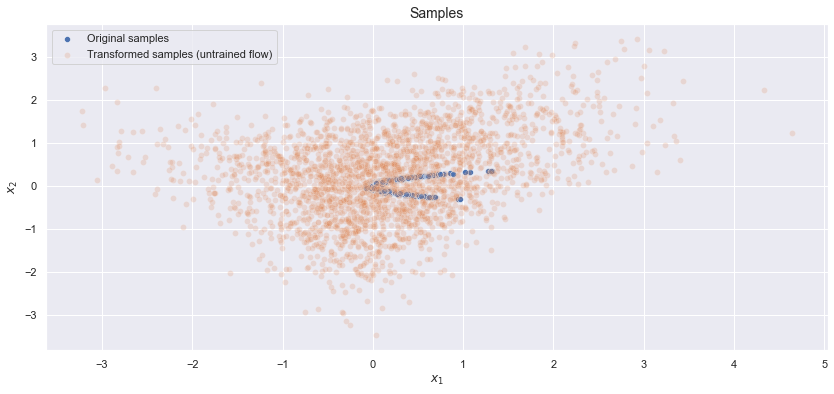

In [190]:
# Sample the source distribution and transform the samples via the
# untrained flow. This should give nothing sensible!
# Note: every time the model is instantiated, the NN weights
#       in it are re-initialized and a different transformation
#       is obtained.
transformed_samples_untrained = test_model.flow.sample((2500))

fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=samples[:, 0].numpy(),
    y=samples[:, 1].numpy(),
    label='Original samples'
)

sns.scatterplot(
    x=transformed_samples_untrained[:, 0].numpy(),
    y=transformed_samples_untrained[:, 1].numpy(),
    label='Transformed samples (untrained flow)',
    alpha=0.2
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

Training.

In [191]:
def nll(samples, distr):
    """
    Negative log likelihood of `samples` according to the
    distribution `distr`.
    """
    return - tf.reduce_mean(distr.log_prob(samples))

In [205]:
model = RealNVP(output_dim=2, num_masked=1, hidden_layers=[32, 32])

loss_history = []
grad_history = []

model(tf.random.uniform((3, 2)))

model.summary()

Instantiating real NVP model with hidden layers
Model: "real_nvp_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 real_nvp_deep_layer_171 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_172 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_173 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_nvp_deep_layer_174 (Re  multiple                 1186      
 alNVPDeepLayer)                                                 
                                                                 
 real_n

In [206]:
@tf.function
def training_step(x):
    """
    """
    with tf.GradientTape() as tape:
        loss = nll(x, model.flow)

    grad = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss, grad

In [207]:
epochs = 4000

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[1000, 2000],
    values=[1e-3, 5e-4, 1e-4]
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

for i in range(epochs):
    loss, grad = training_step(samples)
        
    loss_history.append(loss.numpy())
    # grad_history.append(grad.numpy
    
    if (i < 10) or (i % 200 == 0):
        print(f'Epoch: {i} | Loss: {loss_history[-1]}')
    
loss_history.append(nll(samples, model.flow).numpy())

Epoch: 0 | Loss: 1.8940032720565796
Epoch: 1 | Loss: 1.8847613334655762
Epoch: 2 | Loss: 1.8756136894226074
Epoch: 3 | Loss: 1.8665322065353394
Epoch: 4 | Loss: 1.8574992418289185
Epoch: 5 | Loss: 1.8485137224197388
Epoch: 6 | Loss: 1.8395558595657349
Epoch: 7 | Loss: 1.8306148052215576
Epoch: 8 | Loss: 1.8216736316680908
Epoch: 9 | Loss: 1.8127336502075195
Epoch: 200 | Loss: 0.07732237875461578
Epoch: 400 | Loss: -1.2444400787353516
Epoch: 600 | Loss: -2.082860231399536
Epoch: 800 | Loss: -2.268340587615967
Epoch: 1000 | Loss: -2.6271352767944336
Epoch: 1200 | Loss: -2.9028913974761963
Epoch: 1400 | Loss: -2.852033853530884
Epoch: 1600 | Loss: -2.9209442138671875
Epoch: 1800 | Loss: -2.9337282180786133
Epoch: 2000 | Loss: -2.906663179397583
Epoch: 2200 | Loss: -3.004530668258667
Epoch: 2400 | Loss: -3.024217128753662
Epoch: 2600 | Loss: -3.035255193710327
Epoch: 2800 | Loss: -3.042018175125122
Epoch: 3000 | Loss: -3.04707407951355
Epoch: 3200 | Loss: -3.051543712615967
Epoch: 3400 | L

Text(0.5, 1.0, 'Samples')

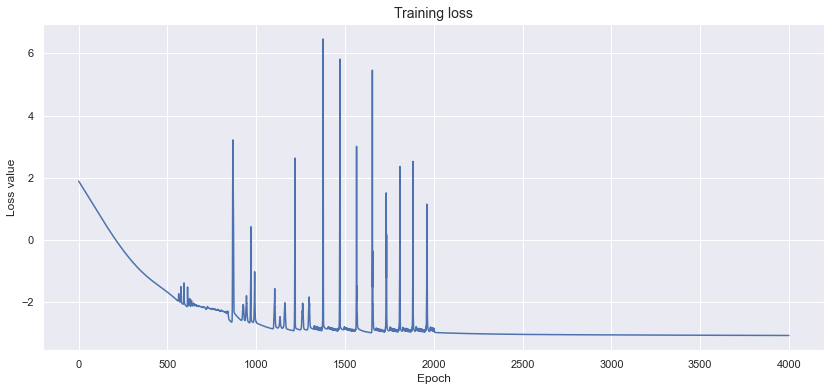

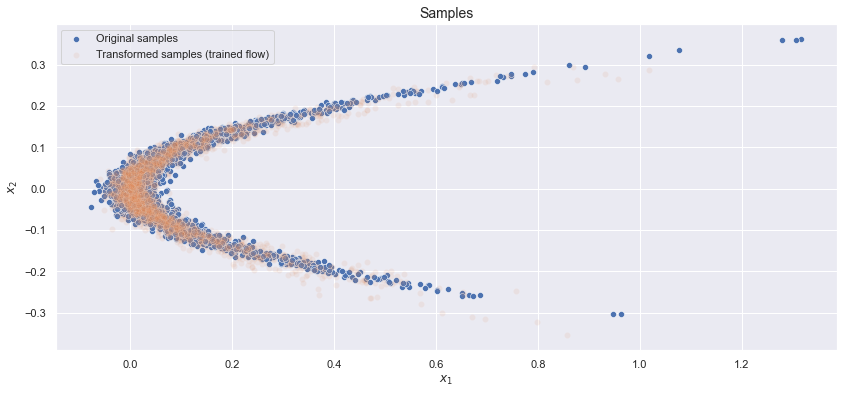

In [215]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(loss_history)),
    y=loss_history
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')



fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=samples[:, 0].numpy(),
    y=samples[:, 1].numpy(),
    label='Original samples'
)

# Sample the source distribution and transform the samples via the
# trained flow. This should give something that looks much more
# like the original samples, as the flow should have understood
# how to map the simple space into the complicated one.
transformed_samples = model.flow.sample((2500))

sns.scatterplot(
    x=transformed_samples[:, 0].numpy(),
    y=transformed_samples[:, 1].numpy(),
    label='Transformed samples (trained flow)',
    alpha=0.1
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

## Map trajectories between the two spaces

Sample points in the simple space (source distribution $p_z$) and in the complicated space (target distribution $p_x$). Again, sampling according to $p_x$ is achieved by sampling $p_z$ and then applying the flow.

Text(0.5, 1.0, 'Complicated space (distr. $p_z$)')

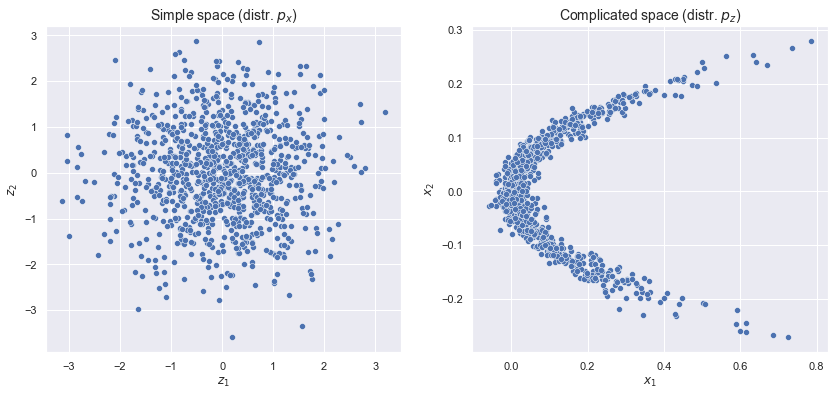

In [252]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

z_samples = model.flow.distribution.sample(1000)

sns.scatterplot(
    x=z_samples[:, 0],
    y=z_samples[:, 1],
    ax=axs[0]
)

plt.sca(axs[0])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Simple space (distr. $p_x$)', fontsize=14)

x_samples = model.flow.sample(1000)

sns.scatterplot(
    x=x_samples[:, 0],
    y=x_samples[:, 1],
    ax=axs[1]
)

plt.sca(axs[1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Complicated space (distr. $p_z$)', fontsize=14)

Define a trajectory in z-space and then map it to a trajectory in x-space using the flow.

In [251]:
# Starting and ending points in z-space.
z_start = tf.constant([[-2., -1.]])
z_end = tf.constant([[1., 1.]])


# Trajectory in z-space.
z_traj = tf.concat(
    [z_start + t * (z_end - z_start) for t in tf.linspace(0., 1., 20)],
    axis=0
)

# Trajectory in x-space, i.e. the image
# of the one in z-space obtained via the trained
# flow.
x_traj = model(x_traj)

Text(0.5, 1.0, 'Complicated space (distr. $p_x$)')

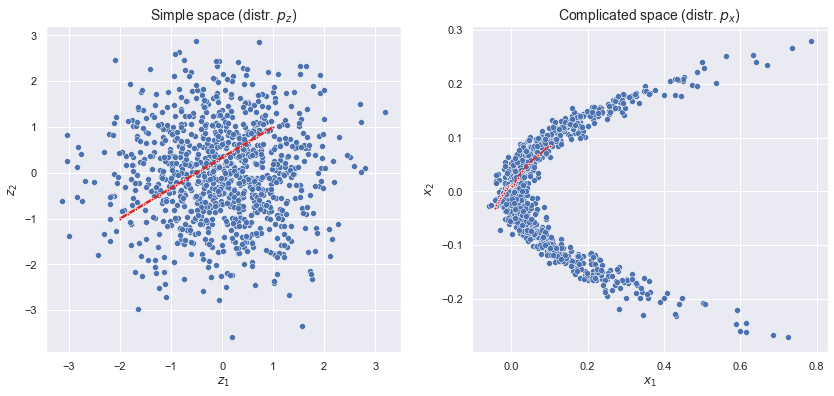

In [253]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.scatterplot(
    x=z_samples[:, 0],
    y=z_samples[:, 1],
    ax=axs[0]
)

sns.lineplot(
    x=z_traj[:, 0],
    y=z_traj[:, 1],
    ax=axs[0],
    color=sns.color_palette("tab10")[3],
    linewidth=2.5,
    marker='.'
)

plt.sca(axs[0])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Simple space (distr. $p_z$)', fontsize=14)

sns.scatterplot(
    x=x_samples[:, 0],
    y=x_samples[:, 1],
    ax=axs[1]
)

sns.lineplot(
    x=x_traj[:, 0],
    y=x_traj[:, 1],
    ax=axs[1],
    color=sns.color_palette("tab10")[3],
    linewidth=1.5,
    marker='.'
)

plt.sca(axs[1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Complicated space (distr. $p_x$)', fontsize=14)